# Django based movie recommender system
## Movie Algorithm- Item_based CF recsys

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
# df_rating = pd.read_csv('https://raw.githubusercontent.com/xiaolancara/Recommender-System/main/data/ml-latest-small/ml-latest-small/ratings.csv').iloc[:,:3]
# df_rating.columns = ['userid', 'movieid', 'ratings']
# # get top 30 popular movies 
# popular_movies = list(df_rating.movieid.value_counts()[:30].index)
# df_rating = df_rating[df_rating['movieid'].isin(popular_movies)]
# vc = df_rating['userid'].value_counts()
# # get user that rated at least 5 movies
# user_index = list(vc[vc>=5].index)
# # subset ratings to 1000
# df_rating = df_rating[df_rating.userid.isin(user_index)][:1000].reset_index(drop=True)
# df_rating

In [3]:
df_rating = pd.read_csv('movie_rating.csv',index_col=0)
df_rating.columns = ['id','userid', 'movieid', 'ratings']
df_rating

,id,userid,movieid,ratings
0,62,1,1,4
1,63,1,2,5
2,64,1,3,5
3,65,1,4,4
4,66,1,5,2
5,67,2,1,4
6,68,2,2,4
7,69,2,3,5
8,70,2,4,3
9,71,2,5,4


In [4]:
df_rating.movieid.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9,  8, 29, 25], dtype=int64)

In [5]:
df_rating.userid.value_counts()

3    8
2    8
1    7
Name: userid, dtype: int64

In [6]:
userRatings = df_rating.pivot_table(index=['userid'],columns=['movieid'],values='ratings')
userRatings

movieid,1,2,3,4,5,6,7,8,9,25,29
userid,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,2.0,NaN,NaN,NaN,NaN,5.0,5.0
2,4.0,4.0,5.0,3.0,4.0,5.0,3.0,NaN,5.0,NaN,NaN
3,5.0,NaN,4.0,NaN,NaN,4.0,5.0,5.0,3.0,5.0,5.0


In [7]:
corrMatrix = userRatings.corr(method='pearson').fillna(0)
corrMatrix

movieid,1,2,3,4,5,6,7,8,9,25,29
movieid,,,,,,,,,,,
1,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0
7,1.0,0.0,-1.0,0.0,0.0,-1.0,1.0,0.0,-1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0


#### Predict ratings for items
The method I use to predict the rating for specific user and item is as below, where K is the neighborhood of most similar items rated by active user a, and w(i,j) is the similarity between items i and j.

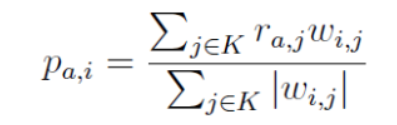

In [8]:
def evaluate():
    df_predict = pd.DataFrame()
    for user_i in userRatings.index:
        myRatings = userRatings.loc[user_i].dropna()

        for movie_i in list(myRatings.index):
            #print(movie_i)
            # retrieve similar movies for movie i
            similar_movies = corrMatrix[movie_i]
            #print(similar_movies)
            # substract to similar score between movie i and rated movies
            similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
#             print(similar_movies)
#             print('----------------')
            # calculate predict rating
            predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
            df_predict = df_predict.append([[user_i, movie_i,predict_ratings]])

    df_predict.columns = ['user_id','movie_id','predict_rating']
    df_predict.reset_index(drop=True,inplace=True)
    
    return df_predict

# evaluate rms
rms = mean_squared_error(df_rating['ratings'], evaluate()['predict_rating'], squared=False)
rms

4.241436711063072

In [9]:
def recommend_movie(user_id, hm):
    myRatings = userRatings.loc[user_id].dropna()
    similar_candidates = pd.DataFrame()
    for i in list(corrMatrix.index):
        # retrieve similar movies for movie i
        similar_movies = corrMatrix[i]
        # substract to similar score between movie i and rated movies
        similar_movies = similar_movies[similar_movies.index.isin(myRatings.index)]
        # calculate predict rating
        predict_ratings = sum(myRatings * similar_movies)/(sum(np.abs(similar_movies))+0.01)
        similar_candidates = similar_candidates.append([predict_ratings])
    similar_candidates.index = corrMatrix.index
    similar_candidates = similar_candidates[~similar_candidates.index.isin(myRatings.index)]
    similar_candidates.columns = ['PredictScore']
    similar_candidates.sort_values(by='PredictScore',inplace=True,ascending=False)    
    return similar_candidates[:hm]
# recommend movies for user_id 31
rec_movie = recommend_movie(user_id=1,hm=10)
rec_movie

,PredictScore
movieid,
6,0.497512
9,0.497512
8,0.000000
7,-0.497512


In [10]:
myRatings = userRatings.loc[1].dropna()
myRatings

movieid
1     4.0
2     5.0
3     5.0
4     4.0
5     2.0
25    5.0
29    5.0
Name: 1, dtype: float64

In [11]:
print('recommend movie id are', list(rec_movie.index))

recommend movie id are [6, 9, 8, 7]
